In [211]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
init_printing()

In [212]:
x = [Symbol(f'x_{{{i}}}', real=True) for i in range(8)]
theta = [Symbol(f'\\theta_{{{i}}}', real=True) for i in range(len(x))]
b = Symbol(f'b', real=True)
Theta = theta + [b]

In [213]:
f = sum(x_*theta_ for x_,theta_ in zip(x,theta)) + b
f = tanh(f) #1/(1+exp(-f))
f

In [214]:
X = (np.random.rand(10, len(x))-0.5)*10
M = np.random.randn(len(x), 1)
Y = X @ M + np.random.randn()
Y = np.tanh(Y)

In [215]:
cost = (1/Y.shape[0])*sum([
    (f.subs({x_:x_sam_ for x_,x_sam_ in zip(x,x_sam)}) - y_sam)**2 for x_sam,y_sam in zip(X,Y)])

In [216]:
grads = [cost.diff(theta_) for theta_ in Theta]
curvs = [grad.diff(theta_) for grad,theta_ in zip(grads,Theta)]

In [217]:
hess = hessian(cost, Theta)
hess = np.array([[lambdify(tuple(Theta), hess[y,x]) for x in range(len(Theta))] for y in range(len(Theta))])

In [218]:
cost = lambdify(tuple(Theta), cost)
grads = np.array([lambdify(tuple(Theta), grad) for grad in grads])
curvs = np.array([lambdify(tuple(Theta), curv) for curv in curvs])

### GD+Moment

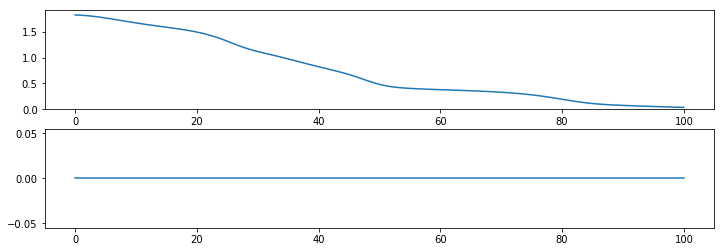

0.03486415829222226 0.2515364662236607 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [219]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
for epoch in range(100):
    mnt_1 = np.zeros_like(para)
    for i in range(len(Theta)):
        mnt_1[i] = 1e-2*grads[i](*para)
    mnt_1 = beta*mnt_old + (1-beta)*mnt_1
    cost_1 = cost(*(para - mnt_1))
    cost_lowest = np.nanargmin([cost_1])
    cost_lowests.append(cost_lowest)
    mnt_old = [mnt_1][cost_lowest]
    para -= mnt_old
    cost_new = [cost_1][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### GD+Moment with cosine annealing

In [109]:
np.cos(0)

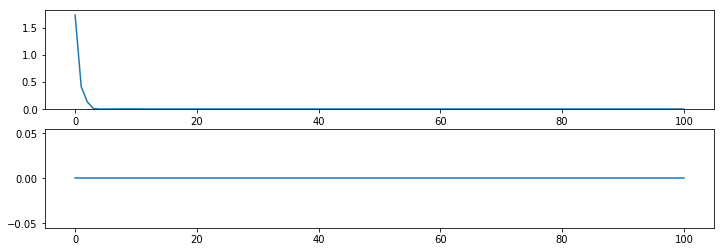

0.0040606486542485104 1.444138768508001e-09 [-1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [246]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
for epoch in range(100):
    mnt_1 = np.zeros_like(para)
    alpha = (np.cos(np.log(epoch+1e-9) * 2*np.pi)+1)/2 * 3
    for i in range(len(Theta)):
        mnt_1[i] = alpha*grads[i](*para)
    mnt_1 = beta*mnt_old + (1-beta)*mnt_1
    cost_1 = cost(*(para - mnt_1))
    cost_lowest = np.nanargmin([cost_1])
    cost_lowests.append(cost_lowest)
    mnt_old = [mnt_1][cost_lowest]
    para -= mnt_old
    cost_new = [cost_1][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### per parameter newton (update at the same time) with GD

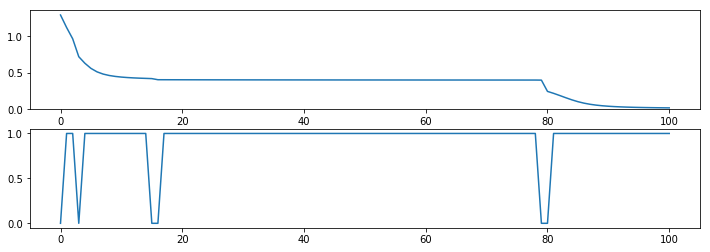

0.018112950362945843 0.07739904354539708 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [221]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    for i in range(len(Theta)):
        para_1[i] = para[i] - grads[i](*para)/abs(curvs[i](*para))
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### per parameter newton (update at the same time) with GD+Moment

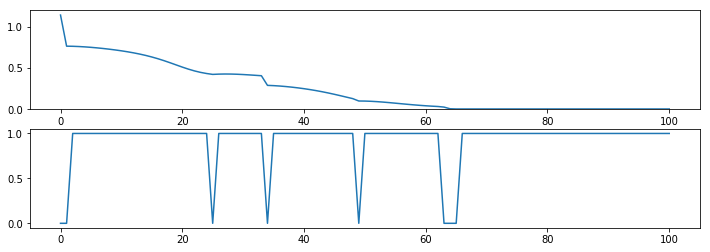

0.002760245946087879 0.0006826249633154463 [ 1. -1. -1.  1.  1.  1.  1.  1.  1.]


In [222]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
for epoch in range(100):
    mnt_1 = np.zeros_like(para)
    mnt_2 = np.zeros_like(para)
    for i in range(len(Theta)):
        mnt_1[i] = grads[i](*para)/abs(curvs[i](*para))
        mnt_2[i] = 1e-2*grads[i](*para)
    mnt_2 = beta*mnt_old + (1-beta)*mnt_2
    cost_1 = cost(*(para - mnt_1))
    cost_2 = cost(*(para - mnt_2))
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para -= [mnt_1,mnt_2][cost_lowest]
    mnt_old = mnt_2
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### per parameter newton (update one by one) with GD

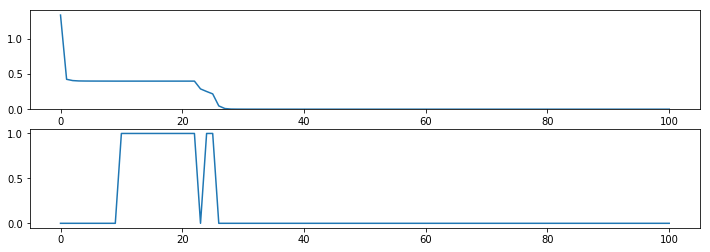

4.285759207547635e-05 5.10196364661598e-07 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [223]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    for i in range(len(Theta)):
        para_1[i] = para_1[i] - grads[i](*para_1)/abs(curvs[i](*para_1))
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### per parameter newton (update one by one) with GD+Moment

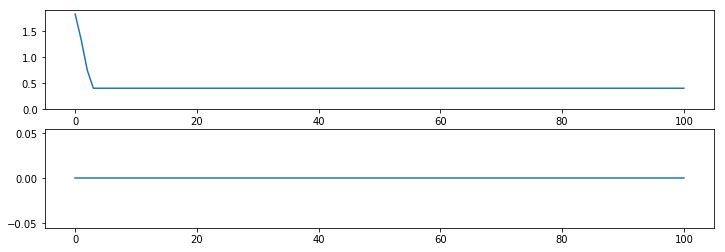

0.403821964388985 1.40950788594216e-13 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [224]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
for epoch in range(100):
    para_1 = np.copy(para)
    mnt_2 = np.zeros_like(para)
    for i in range(len(Theta)):
        para_1[i] = para_1[i] - grads[i](*para_1)/abs(curvs[i](*para_1))
        mnt_2[i] = 1e-2*grads[i](*para)
    mnt_2 = beta*mnt_old + (1-beta)*mnt_2
    cost_1 = cost(*(para_1))
    cost_2 = cost(*(para - mnt_2))
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para-mnt_2][cost_lowest]
    mnt_old = mnt_2
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton hessian with GD

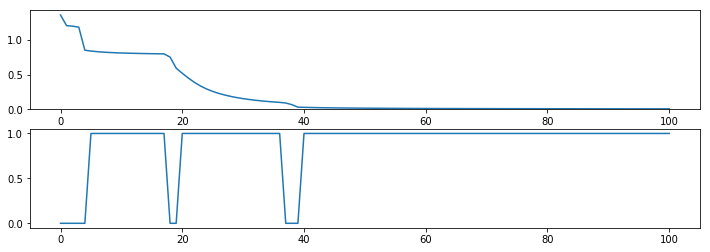

0.004986586026972569 0.006147538483423611 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [251]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    g = np.array([grad(*para) for grad in grads])
    try:
        h_inv = np.linalg.inv(np.array([[h(*para) for h in hy] for hy in hess]))
        para_1 = para_1 - np.abs(h_inv @ g) * np.sign(g)
    except:
        para_1 = np.full_like(para_1, np.nan)
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton partial hessian with GD with cosine annealing

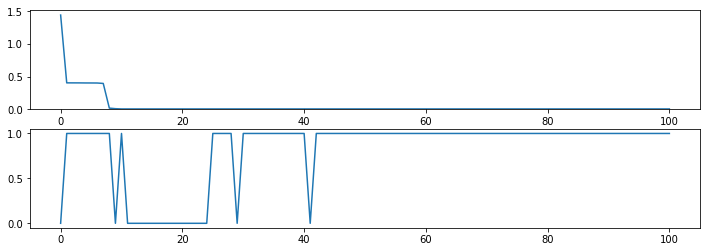

0.0040590346857770744 7.053998096472795e-11 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [262]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    z = np.array(np.random.choice(range(len(Theta)), size=4, replace=False))
    g = np.array([grad(*para) for grad in grads[z]])
    try:
        h_inv = np.linalg.inv(np.array([[h(*para) for h in hy[z]] for hy in hess[z]]))
        para_1[z] = para_1[z] - (h_inv @ g)
    except:
        break
        para_1[z] = np.full_like(para_1[z], np.nan)
    alpha = (np.cos(np.log(epoch+1e-9) * 2*np.pi)+1)/2 * 3
    for i in range(len(Theta)):
        para_2[i] = para[i] - alpha*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### newton partial hessian with GD

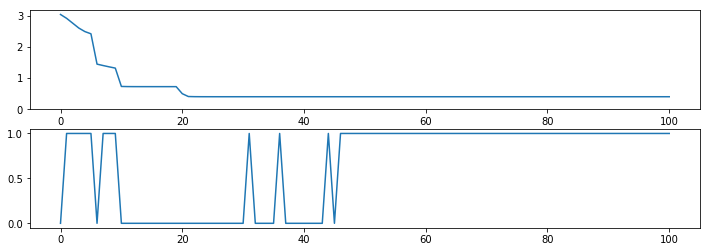

0.3997747211684686 6.430262997981842e-19 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [255]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    z = np.array(np.random.choice(range(len(Theta)), size=4, replace=False))
    g = np.array([grad(*para) for grad in grads[z]])
    try:
        h_inv = np.linalg.inv(np.array([[h(*para) for h in hy[z]] for hy in hess[z]]))
        para_1[z] = para_1[z] - (h_inv @ g)
    except:
        break
        para_1[z] = np.full_like(para_1[z], np.nan)
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### bb method with GD

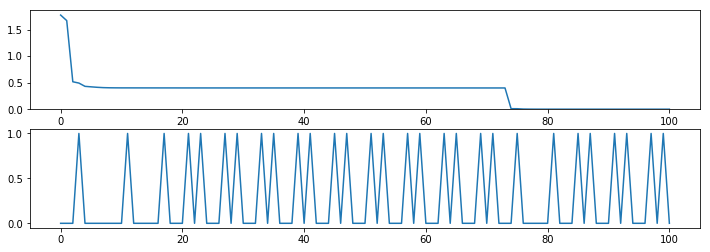

0.00010170113165130208 1.1632551187849674e-06 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [227]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
alpha = 1e-2
for epoch in range(100):
    para_1 = np.copy(para)
    para_2 = np.copy(para)
    g = np.array([grad(*para) for grad in grads])
    if epoch > 0:
        g_d = g - g_old
        para_d = para - para_1_old
        alpha = (para_d @ para_d) / (para_d @ g_d)
    g_old = np.copy(g)
    para_1_old = np.copy(para)
    para_1 = para - alpha*g
    for i in range(len(Theta)):
        para_2[i] = para[i] - 1e-2*grads[i](*para)
    cost_1 = cost(*para_1)
    cost_2 = cost(*para_2)
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para = [para_1,para_2][cost_lowest]
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))

### bb method with GD+Moment

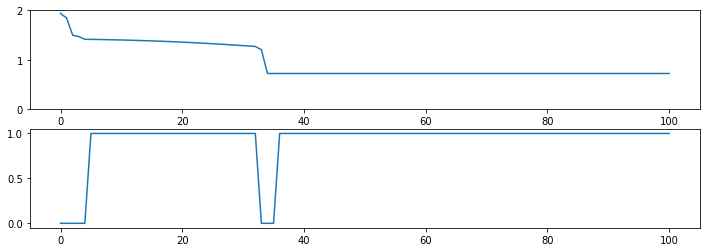

0.7230635783779645 4.726720338123737e-06 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [242]:
para = np.random.randn(len(Theta)) * (2/len(x))
cost_hist = [cost(*para)]
cost_lowests = [0]
mnt_old = 0.
beta = 0.9
alpha = 1e-2
for epoch in range(100):
    mnt_1 = np.zeros_like(para)
    mnt_2 = np.zeros_like(para)
    g = np.array([grad(*para) for grad in grads])
    if epoch > 0:
        g_d = g - g_old
        para_d = para - para_1_old
        alpha = (para_d @ para_d) / (para_d @ g_d)
    g_old = np.copy(g)
    para_1_old = np.copy(para)
    mnt_1 = alpha*g
    for i in range(len(Theta)):
        mnt_2[i] = 1e-2*grads[i](*para)
    mnt_2 = beta*mnt_old + (1-beta)*mnt_2
    cost_1 = cost(*(para - mnt_1))
    cost_2 = cost(*(para - mnt_2))
    cost_lowest = np.nanargmin([cost_1,cost_2])
    cost_lowests.append(cost_lowest)
    para -= [mnt_1,mnt_2][cost_lowest]
    mnt_old = mnt_2
    cost_new = [cost_1,cost_2][cost_lowest]
    cost_hist.append(cost_new)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(cost_hist)
plt.ylim((0, None))
plt.subplot(2,1,2)
plt.plot(cost_lowests)
plt.show()
print(cost_new, sum(grad(*para)**2 for grad in grads), np.sign([curv(*para) for curv in curvs]))